# Learning Spatial Relationships with MISTy


### Import generic packages

In [1]:
import scanpy as sc
import squidpy as sq
import decoupler as dc
import plotnine as p9
import liana as li

In [6]:
import numpy as np

### Import helper functions and Pre-defined single view models 

In [2]:
from liana.method import MistyData, genericMistyData, lrMistyData
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel

### Load and normalize data

In [4]:
folder    = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
adata_s1   = sc.read(filename = folder + 'S1_niche_label_annotated.h5ad')
adata_s1

AnnData object with n_obs × n_vars = 104816 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [7]:
adata = adata_s1[np.isin(adata_s1.obs['fov'],['10'])].copy()
adata

AnnData object with n_obs × n_vars = 4423 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'niche_label'
    uns: 'cell_type_coarse_colors', 'spatial', 'spatial_neighbors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [8]:
adata.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

In [ ]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Functional analysis

#### pathway activity

In [9]:
# obtain genesets
progeny = dc.get_progeny(organism='human', top=500)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to download from `https://omnipathdb.org/`.
Traceback (most recent call last):
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1058, in _validate_conn
    conn.connect()
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
  File "/home/aih/sara.jimenez/

In [10]:
# use multivariate linear model to estimate activity
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

Running mlm on mat with 4423 samples and 979 targets for 14 sources.


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


In [11]:
# extract progeny activities as an AnnData object
acts_progeny = li.ut.obsm_to_adata(adata, 'mlm_estimate')

In [12]:
acts_progeny.var_names

Index(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype='object')

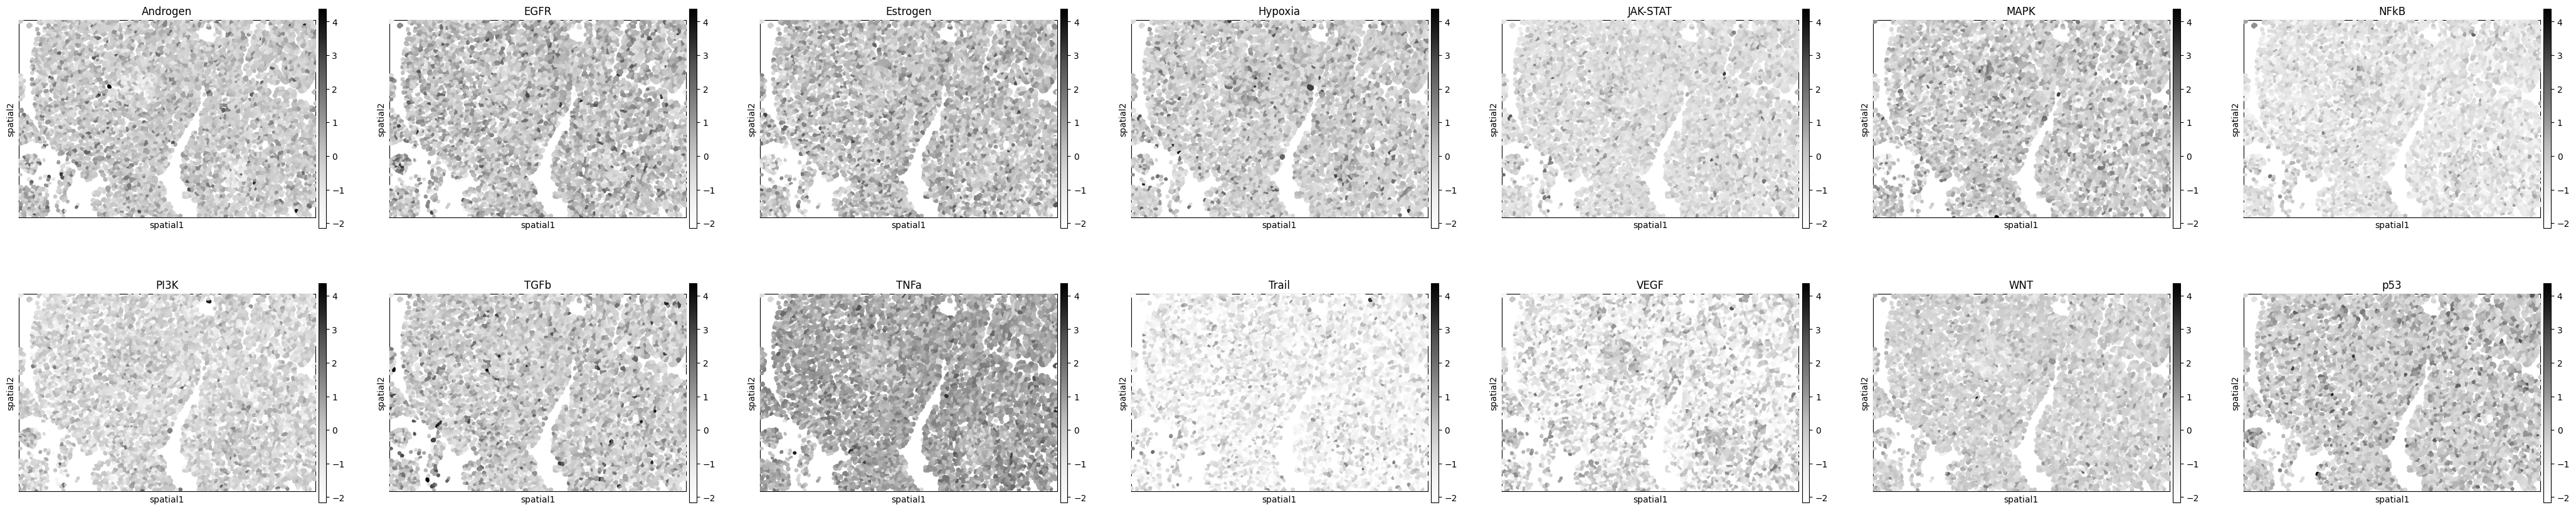

In [13]:
# Check how the pathway activities look like
sq.pl.spatial_segment(acts_progeny,color=['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],ncols=7,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

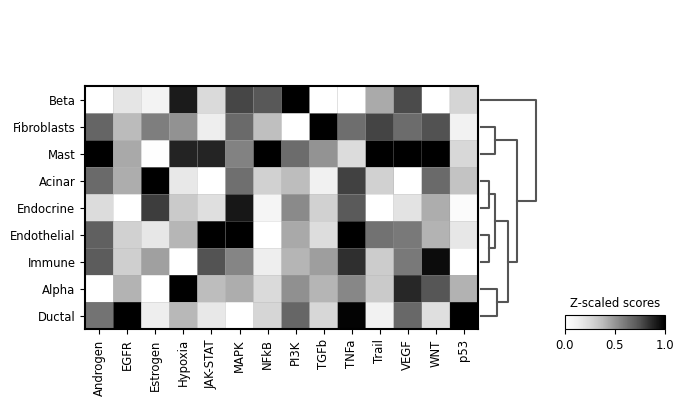

In [15]:
sc.pl.matrixplot(acts_progeny, var_names=acts_progeny.var_names, groupby='cell_type_coarse', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

#### TF activity inference

In [16]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [17]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running ulm on mat with 4423 samples and 979 targets for 469 sources.


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


In [18]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

In [19]:
acts.var_names

Index(['ABL1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A', 'ARID4B', 'ARNT',
       'ARX',
       ...
       'ZKSCAN7', 'ZMYND8', 'ZNF148', 'ZNF300', 'ZNF354C', 'ZNF362', 'ZNF382',
       'ZNF384', 'ZNF699', 'ZNF91'],
      dtype='object', length=469)

In [24]:
df = dc.rank_sources_groups(acts, groupby='cell_type_coarse', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,Acinar,rest,ZNF362,47.508543,1.385158,0.000000e+00,0.000000e+00
1,Acinar,rest,NR0B2,44.174765,1.341274,0.000000e+00,0.000000e+00
2,Acinar,rest,KLF5,42.808693,0.933105,0.000000e+00,0.000000e+00
3,Acinar,rest,PAX3,31.665374,0.628849,5.386517e-202,1.148307e-200
4,Acinar,rest,SOX6,28.973928,1.110902,2.432374e-168,2.925086e-167
...,...,...,...,...,...,...,...
4216,Mast,rest,KLF8,-5.503178,-1.141600,4.203697e-07,2.816477e-05
4217,Mast,rest,NR0B2,-6.041281,-1.337344,4.014996e-08,4.707582e-06
4218,Mast,rest,KLF5,-6.045386,-1.190418,3.689069e-08,4.707582e-06
4219,Mast,rest,HNF1A,-6.888323,-1.604395,8.097249e-10,1.898805e-07


In [25]:
n_markers = 5
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'Acinar': ['ZNF362', 'NR0B2', 'KLF5', 'PAX3', 'SOX6'],
 'Alpha': ['MAF', 'FOXA2', 'MAFB', 'HNF4A', 'ONECUT1'],
 'Beta': ['ZGLP1', 'MAFA', 'ISL1', 'ONECUT1', 'CDX2'],
 'Ductal': ['HSF2', 'MYBL2', 'SP1', 'TCF4', 'SP4'],
 'Endocrine': ['FOXA2', 'ONECUT1', 'MAFA', 'MAFB', 'HNF4A'],
 'Endothelial': ['HIVEP2', 'CIITA', 'ERG', 'GATA2', 'NFIX'],
 'Fibroblasts': ['SKIL', 'SMAD3', 'JDP2', 'CUX1', 'TAF1'],
 'Immune': ['CIITA', 'RFXANK', 'RFXAP', 'RFX5', 'NFYB'],
 'Mast': ['SKIL', 'SPIB', 'JDP2', 'NFKB1', 'MYB']}

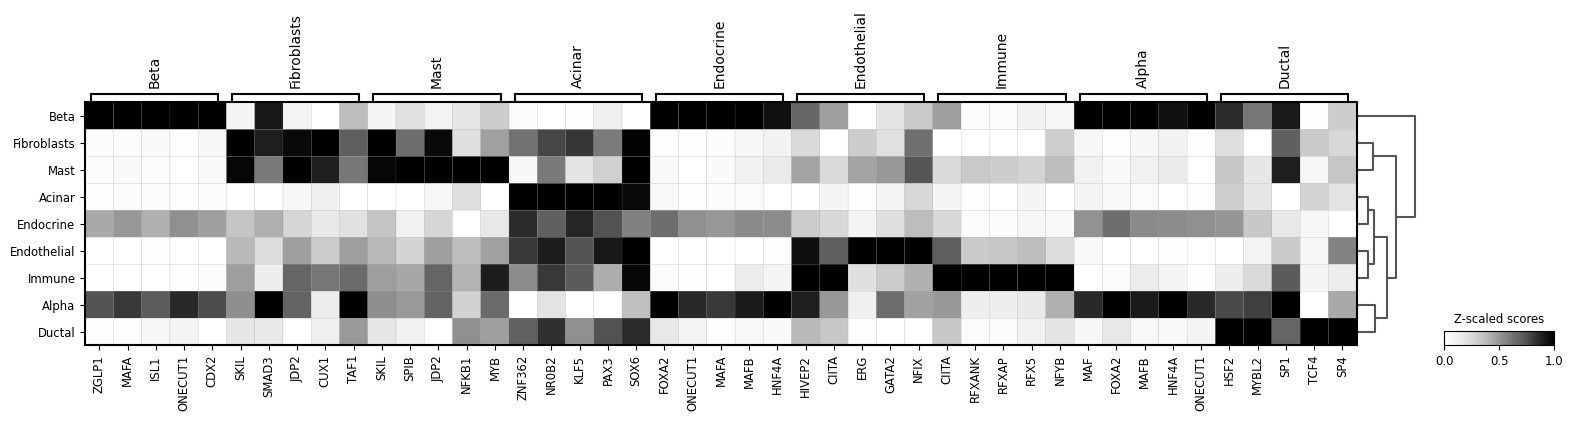

In [26]:
sc.pl.matrixplot(acts, source_markers, 'cell_type_coarse', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

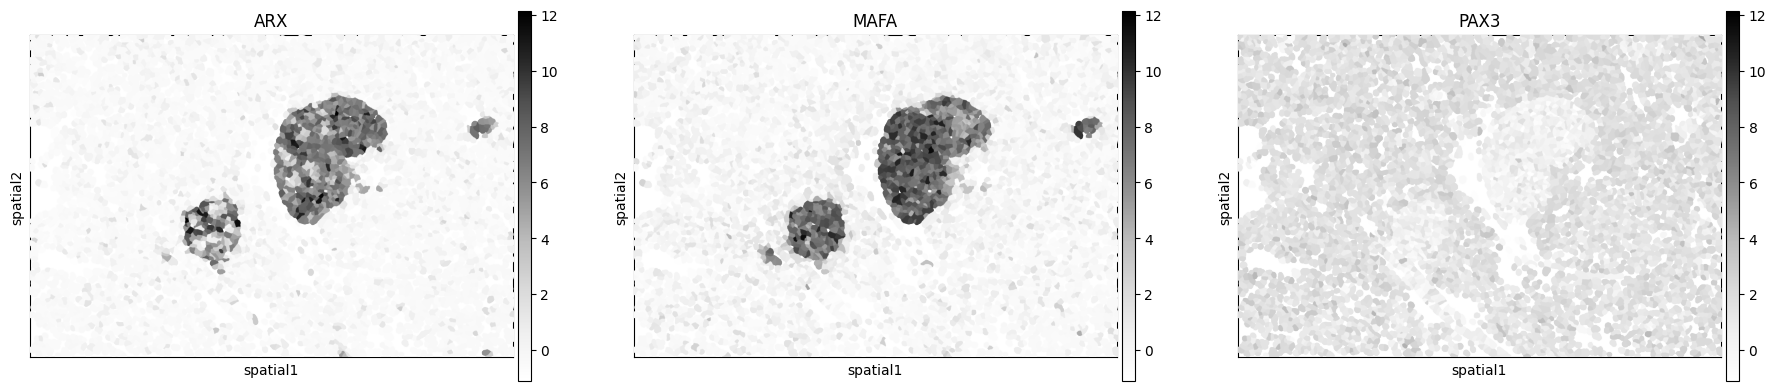

In [16]:
sq.pl.spatial_segment(acts,color=['ARX','MAFA', 'PAX3'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)